In [539]:
import random
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore')

InteractiveShell.ast_node_interactivity = "all"  # "last_expr"

%pylab inline
%matplotlib inline

np.random.seed(1)
np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.5f}'.format})

# %%writefile template.py#
# %load template.py - внешний файл
# %lsmagic

Populating the interactive namespace from numpy and matplotlib


In [540]:
from os import walk
from collections import defaultdict
import re

files = []
for (dirpath, dirnames, filenames) in walk("./messages/"):
    files.extend(filenames)
    break

X = []
Y = []
for file in files:
    with open("./messages/" + file, "r") as f:
        header = f.readline()
        no = f.readline()
        message = f.readline()
        pred = re.search("^.*legit.*$", file)
        if (pred):
            Y.append(0)
        else:
            Y.append(1)
        tmp_arr = np.array(" ".join(header.split()[1:]) + " " + message).astype(str)
        X.append(tmp_arr)
        
X = np.array(X)
Y = np.array(Y)

In [541]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer()
c_vec.fit(X)
# c_vec.get_feature_names()
doc_array = c_vec.transform(X).toarray()
doc_array.shape
X_vec = c_vec.fit_transform(X).toarray()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

(1090, 24718)

In [545]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, train_size=0.8)

In [546]:
freq_matrix = pd.DataFrame(doc_array, columns=c_vec.get_feature_names())
freq_matrix

,10,100,1000,10000,10001,10002,10003,10004,10005,10006,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [549]:
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, auc, accuracy_score

r2:         0.6649590163934427
recall:     0.825
precision:  0.9851365711025529
f1:         0.8972569050628227
accuracy:   0.9174311926605506
roc_auc:    0.9912568306010929


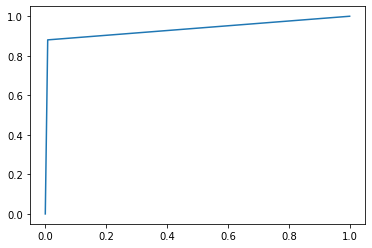

In [548]:
scores = cross_validate(BernoulliNB(), X_vec, Y, cv=10,
                        scoring=('r2', 'recall', 'precision',
                                 'f1', 'accuracy', 'roc_auc'),
                        return_train_score=True)

fpr, tpr, thresholds = roc_curve(Y_test, BernoulliNB().fit(X_train, Y_train).predict(X_test))
plt.plot(fpr, tpr)
print("r2:        ", sum(scores['test_r2']) / 10)
print("recall:    ", sum(scores['test_recall']) / 10)
print("precision: ", sum(scores['test_precision']) / 10)
print("f1:        ", sum(scores['test_f1']) / 10)
print("accuracy:  ", sum(scores['test_accuracy']) / 10)
print("roc_auc:   ", sum(scores['test_roc_auc']) / 10)

In [623]:
tmp_alpha1 = np.arange(1e-11, 1e10, 5e8).reshape(-1, 1)
tmp_alpha2 = np.array([1e-11] * len(tmp_alpha1)).reshape(-1, 1)

fog_gc = np.append(tmp_alpha1, tmp_alpha2, axis=1).tolist()

In [616]:
best_score_pre = 0
for i in fog_gc:
    clf = BernoulliNB(class_prior=i)
    clf = clf.fit(X_vec, Y)
    Y_pred = clf.predict(X_vec)
    pre = precision_score(Y, Y_pred)
    if (pre > best_score_pre):
        best_score_pre = pre
        best_grid_pre = i


print("Best params for precision:",best_grid_pre)
print("Best score:", best_score_pre)


Best params for precision: [4000000000.0, 1e-11]
Best score: 1.0


Confusion Matrix: precision = 1.0


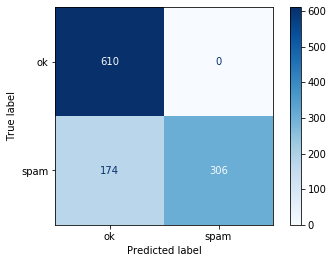

In [618]:
from sklearn.metrics import plot_confusion_matrix
clf1 = BernoulliNB(class_prior=[4000000000.0, 1e-11])
clf1 = clf1.fit(X_vec, Y)

plot_confusion_matrix(clf1, X_vec, Y,
                      cmap=plt.cm.Blues,
                      display_labels=["ok", "spam"],
                      values_format='d')
print("Confusion Matrix: precision = 1.0")

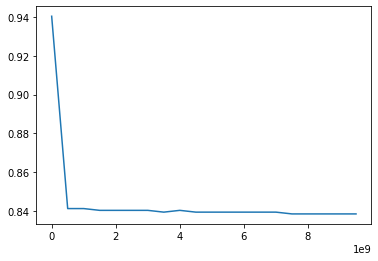

In [596]:
scores = []
alpha = []
for i in fog_gc:
    clf = BernoulliNB(class_prior=i)
    clf = clf.fit(X_vec, Y)
    scores.append(accuracy_score(Y, clf.predict(X_vec)))
    alpha.append(i[0])

plt.plot(alpha, scores)

In [636]:
tmp_alpha1 = np.arange(1, 1e5, 1000).reshape(-1, 1)
tmp_alpha2 = np.array([1e15] * len(tmp_alpha1)).reshape(-1, 1)

fog_gc = np.append(tmp_alpha1, tmp_alpha2, axis=1).tolist()

best_score = 0
for i in fog_gc:
    clf = BernoulliNB(class_prior=i)
    clf = clf.fit(X_vec, Y)
    Y_pred = clf.predict(X_vec)
    acc = accuracy_score(Y, Y_pred)
    if (acc > best_score):
        best_score = acc
        best_grid = i


print("Best params:", best_grid)
print("Best score:", best_score)

Best params: [29001.0, 1000000000000000.0]
Best score: 0.9844036697247707


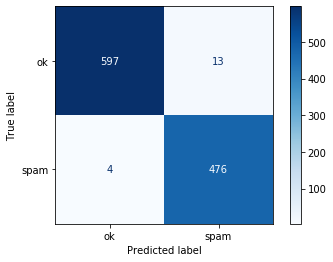

In [637]:
clf1 = BernoulliNB(class_prior=best_grid)
clf1 = clf1.fit(X_vec, Y)

plot_confusion_matrix(clf1, X_vec, Y,
                      cmap=plt.cm.Blues,
                      display_labels=["ok", "spam"],
                      values_format='d')